Данные

In [1]:
import warnings
from typing import Optional, Tuple
import torch.nn as nn
import torch.nn.functional as F
import torch
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.utils.data import DataLoader
import math

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

warnings.filterwarnings("ignore")

In [2]:
!git clone https://github.com/mdeff/fma.git

Cloning into 'fma'...
remote: Enumerating objects: 823, done.
remote: Counting objects: 100% (822/822), done.
remote: Compressing objects: 100% (287/287), done.
remote: Total 823 (delta 532), reused 621 (delta 527), pack-reused 1
Receiving objects: 100% (823/823), 4.08 MiB | 10.01 MiB/s, done.
Resolving deltas: 100% (532/532), done.


In [2]:
SEED = 777

np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

In [8]:
!python -m pip install python-dotenv

In [9]:
import os
os.sys.path.append("../fma/")
from fma import utils

In [13]:
!cd fma

In [14]:
!ls fma

analysis.ipynb	 creation.py  figures	   __pycache__	     setup.py	  webapi.ipynb
baselines.ipynb  data	      LICENSE.txt  README.md	     usage.ipynb
creation.ipynb	 features.py  makefile	   requirements.txt  utils.py


In [17]:
!cd fma/data

In [18]:
!ls fma/data

In [19]:
!curl -O https://os.unil.cloud.switch.ch/fma/fma_metadata.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  341M  100  341M    0     0  24.3M      0  0:00:14  0:00:14 --:--:-- 26.7M


In [20]:
!unzip fma_metadata.zip

Archive:  fma_metadata.zip
 bunzipping: fma_metadata/README.txt  
 bunzipping: fma_metadata/checksums  
 bunzipping: fma_metadata/not_found.pickle  
 bunzipping: fma_metadata/raw_genres.csv  
 bunzipping: fma_metadata/raw_albums.csv  
 bunzipping: fma_metadata/raw_artists.csv  
 bunzipping: fma_metadata/raw_tracks.csv  
 bunzipping: fma_metadata/tracks.csv  
 bunzipping: fma_metadata/genres.csv  
 bunzipping: fma_metadata/raw_echonest.csv  
 bunzipping: fma_metadata/echonest.csv  
 bunzipping: fma_metadata/features.csv  


In [21]:
tracks = utils.load('fma_metadata/tracks.csv')
genres = utils.load('fma_metadata/genres.csv')

tracks.shape, genres.shape,

((106574, 52), (163, 4))

In [24]:
tracks.head()

album                                                          \
         comments        date_created date_released engineer favorites id   
track_id                                                                    
2               0 2008-11-26 01:44:45    2009-01-05      NaN         4  1   
3               0 2008-11-26 01:44:45    2009-01-05      NaN         4  1   
5               0 2008-11-26 01:44:45    2009-01-05      NaN         4  1   
10              0 2008-11-26 01:45:08    2008-02-06      NaN         4  6   
20              0 2008-11-26 01:45:05    2009-01-06      NaN         2  4   

                                                                           \
                                        information listens producer tags   
track_id                                                                    
2                                           <p></p>    6073      NaN   []   
3                                           <p></p>    6073      NaN   []   
5                                           <p></p>    6073      NaN   []   
10                                              NaN   47632      NaN   []   
20        <p> "spiritual songs" from Nicky Cook</p>    2710      NaN   []   

          ...       track                         \
          ... information interest language_code   
track_id  ...                                      
2         ...         NaN     4656            en   
3         ...         NaN     1470            en   
5         ...         NaN     1933            en   
10        ...         NaN    54881            en   
20        ...         NaN      978            en   

                                                                              \
                                                    license listens lyricist   
track_id                                                                       
2         Attribution-NonCommercial-ShareAlike 3.0 Inter...    1293      NaN   
3         Attribution-NonCommercial-ShareAlike 3.0 Inter...     514      NaN   
5         Attribution-NonCommercial-ShareAlike 3.0 Inter...    1151      NaN   
10        Attribution-NonCommercial-NoDerivatives (aka M...   50135      NaN   
20        Attribution-NonCommercial-NoDerivatives (aka M...     361      NaN   

                                                 
         number publisher tags            title  
track_id                                         
2             3       NaN   []             Food  
3             4       NaN   []     Electric Ave  
5             6       NaN   []       This World  
10            1       NaN   []          Freeway  
20            3       NaN   []  Spiritual Level  

[5 rows x 52 columns]

In [23]:
small = tracks[tracks['set', 'subset'] <= 'small']

In [25]:
genre_to_index = {k:i for i, (k, v) in enumerate(small.track['genre_top'].value_counts().to_dict().items()) if v > 0}
genre_to_index

{'Electronic': 0,
 'Experimental': 1,
 'Folk': 2,
 'Hip-Hop': 3,
 'Instrumental': 4,
 'International': 5,
 'Pop': 6,
 'Rock': 7}

In [32]:
import torch
import torch.nn as nn
import torch.utils.data as torch_data
import pandas as pd
import librosa
import librosa.display
import IPython.display as ipd

In [34]:
!curl -O https://os.unil.cloud.switch.ch/fma/fma_small.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 7323M  100 7323M    0     0  26.5M      0  0:04:35  0:04:35 --:--:-- 26.9M


In [3]:
#!unzip fma_small.zip

In [38]:
AUDIO_DIR = "fma_small"

In [39]:
filename = utils.get_audio_path(AUDIO_DIR, 2)
print('File: {}'.format(filename))

x, sr = librosa.load(filename, sr=None, mono=True)
print('Duration: {:.2f}s, {} samples'.format(x.shape[-1] / sr, x.size))

start, end = 7, 17
ipd.Audio(data=x[start*sr:end*sr], rate=sr)

File: fma_small/000/000002.mp3
Duration: 29.98s, 1321967 samples


In [40]:
PIECE_LEN = 2**15*6 # применро 4,45 сек


class Dataset(torch_data.Dataset):
    def __init__(self, data: pd.DataFrame):
        self.wav = []
        self.genres = []

        self.genre_to_index = {k:i for i, (k, v) in enumerate(small.track['genre_top'].value_counts().to_dict().items()) if v > 0}
        self.index_to_genre = {v:k for k, v in self.genre_to_index.items()}


        for i in tqdm(data.track[['duration', 'genre_top']].index):
            row = data.track.loc[i, ['duration', 'genre_top']]
            filename = utils.get_audio_path(AUDIO_DIR, i)
            try:
                x, sr = librosa.load(filename, sr=None, duration=row.duration, mono=True)

                if sr != 44100 or len(x) < PIECE_LEN:
                    continue
                self.wav.append(x)
                self.genres.append(self.genre_to_index[row.genre_top])
            except:
                print(f"File {i} is broken")

    def __getitem__(self, index):
        start = np.random.choice(len(self.wav[index]) - PIECE_LEN, size=1)[0]
        return self.wav[index][start: start + PIECE_LEN], self.genres[index]

    def __len__(self) -> int:
        return len(self.wav)


def collate_fn(batch) -> tuple[torch.Tensor, torch.Tensor]:
    arr = np.array([item[0] for item in batch])
    wav = torch.tensor(arr, dtype=torch.float)
    g = np.array([item[1] for item in batch])
    genres = torch.tensor(g, dtype=torch.int)

    return (wav, genres)

In [43]:
from tqdm import tqdm

In [ ]:
dataset = Dataset(small)

 27%|██▋       | 2167/8000 [03:33<09:15, 10.50it/s]

In [42]:
dataloader = torch_data.DataLoader(
    dataset,
    batch_size=8,
    shuffle=True,
    num_workers=8,
    collate_fn=collate_fn
)

NameError: name 'dataset' is not defined

DDPM (пока без Sampling with guidance gradients)

### Напоминание (чтобы все было в одном месте для удобства)

Диффузионная модель состоит из прямого и обратного процесса. Прямой диффузионный процесс определяется как апостериорное распределение $q(x_{1:T}|x_0)$. Это распределение также является Марковской цепочкой, которая постепенно добавляет гауссовский шум к данному начальному объекту $x_0$. На каждом шаге шум добавляется с различной магнитудой, которая определяется расписанием дисперсий
 $\{\beta_1, ... \beta_T\}$. При правильном выборе расписания в пределе по числу шагов $T$ мы должны сойтись к шуму из $\mathcal{N}(0, I)$. В качестве распределений $q$ берут нормальные распределения:
$$
 q(x_t | x_{t - 1}) := \mathcal{N}(x_t; \sqrt{1 - \beta_t}x_{t - 1}, \beta_tI), \ \ \ \ \ \ \ q(x_{1:T}|x_0) = \prod_{t = 1}^T q(x_t | x_{t - 1})
$$

Теперь посмотрим со стороны обратного процесса. Обратный процесс расшумляет шум, пока не получится объект из изначального распределения. Таким образом, диффузионная модель - это вероятностная модель с латентными переменными вида $p_\theta(x_0) := \int p_\theta(x_{0:T}) dx_{1:T}$, где промежуточные состояния $x_1, ..., x_T$ соответствуют зашумленным объектам, a $x_0$ - объект из распределения. Совместное распределение $p_\theta(x_{0:T})$ называет обратным диффузионным процессом, который представляет собой Марковскую цепочку из гауссовских распределений $p_\theta(x_{i-1}|x_{i})$:

$$
p(x_{0:T}) = p(x_0) \prod_{t = 1}^Tp_{\theta}(x_{t-1}|x_t) \ \ \ \ \ \ \ \ \ p_\theta(x_{T})=\mathcal{N}(x_T | 0, I)
$$
$$
  p_{\theta}(x_{t - 1}|x_t):= \mathcal{N}(x_{t - 1}; \mu_{\theta}(x_t, t), \Sigma_{\theta}(x_t, t))
$$

Вернемся к распределению $q(x_t | x_{t - 1})$.  Для того чтобы получить $x_t$, придется итеративно получать $x_1, ..., x_{t - 1}$. Однако это можно сделать более эффективно благодаря нормальным распределениям. Для этого обозначим $\alpha_t := 1- \beta_t$ и $\bar{\alpha}_t:= \prod_{i = 1}^t\alpha_i$, тогда
$$
q(x_t | x_0) = \mathcal{N}(x_t;\sqrt{\bar{\alpha}_t} x_0, (1-\bar{\alpha}_t)I) \quad \quad \quad \quad \quad \quad (1)
$$

Затем модель можно обучать, оптимизируя отдельные члены суммы вариационной нижней оценки $\log p_{\theta}(x_0)$:
$$
L_{VLB} = \mathbb{E}_q [\underbrace{D_\text{KL}(q(\mathbf{x}_T |
\mathbf{x}_0) \parallel p_\theta(\mathbf{x}_T))}_{L_T} + + \sum_{t=2}^T
\underbrace{D_\text{KL}(q(\mathbf{x}_{t-1} | \mathbf{x}_t,
\mathbf{x}_0) \parallel p_\theta(\mathbf{x}_{t-1}
| \mathbf{x}_t))}_{L_{t-1}} \underbrace{- \log p_\theta(\mathbf{x}_0
| \mathbf{x}_1)}_{L_0}
$$

Для обучение нужно лишь выписать $q(\mathbf{x}_{t-1} | \mathbf{x}_t, \mathbf{x}_0) = \mathcal{N}(\mathbf{x}_{t-1}; \boldsymbol{\mu}(\mathbf{x}_t, \mathbf{x}_0), \tilde{\beta}_t \mathbf{I}) $:

$$
    \boldsymbol{\mu}(\mathbf{x}_t, \mathbf{x}_0) = \frac{\sqrt{\alpha_t}(1 - \bar{\alpha}_{t-1})}{1 - \bar{\alpha}_t} \mathbf{x}_t + \frac{\sqrt{\bar{\alpha}_{t-1}}\beta_t}{1 - \bar{\alpha}_t} \mathbf{x}_0 \ \ \ \ \ \ (2)
$$
$$
    \tilde{\beta}_t = \frac{1 - \bar{\alpha}_{t-1}}{1 - \bar{\alpha}_t} \cdot \beta_t  \quad \quad \quad \quad \quad \quad \quad (3)
$$


Cтатья - [Denoising Diffusion Probabilistic Models (Ho et al. 2020)](https://arxiv.org/abs/2006.11239).

В статье было показано, что обучаясь на более простой лосс, получаются результаты лучше.  

Итак, заметим, что
$$
x_t(x_0, \epsilon) = \sqrt{\bar{\alpha}_t} x_0 +  \sqrt{1-\bar{\alpha}_t}\epsilon, \ \ \ \epsilon \sim \mathcal{N}(0, I) \quad \quad \quad \quad \quad \quad \quad (4)
$$

Тогда пускай наша модель с весами $\theta$ будет предсказывать $\epsilon$ из равенства выше, а именно обучаться, минимизируя данную функцию потерь:

$$L^{simple}_t = \mathbb{E}_{x_0, \epsilon, t}\bigg[ \|\epsilon - \epsilon_{\theta}(x_t, t)\|^2\bigg]$$

Именно этот лосс мы будем использовать.


Чтобы сэмплировать (обратный процесс), нам нужно получить $\mu_{\theta}(x_t, x_0)$ из $\epsilon_{\theta}(x_t, t)$. Для этого получаем $\hat{x}_0(\epsilon_{\theta}, x_t)$ из уравнения (4) и подставляем его в равенство (2).

In [4]:
# utility function. basicalle, returns arr[timesteps], where timesteps are indices
def _extract_into_tensor(arr, timesteps, broadcast_shape):
    """
    Extract values from a 1-D torch tensor for a batch of indices.
    :param arr: 1-D torch tensor.
    :param timesteps: a tensor of indices into torche array to extract.
    :param broadcast_shape: a larger shape of K dimensions witorch torche batch
                            dimension equal to torche lengtorch of timesteps.
    :return: a tensor of shape [batch_size, 1, ...] where torche shape has K dims.
    """
    res = arr.to(device=timesteps.device)[timesteps].float()
    while len(res.shape) < len(broadcast_shape):
        res = res[..., None]
    return res.expand(broadcast_shape)

# out beta_t. we use linear scheduler
def get_named_beta_schedule(schedule_name, num_diffusion_timesteps):
    """
    Get a pre-defined beta schedule for the given name.
    The beta schedule library consists of beta schedules which remain similar
    in the limit of num_diffusion_timesteps.
    Beta schedules may be added, but should not be removed or changed once
    they are committed to maintain backwards compatibility.
    """
    scale = 1000 / num_diffusion_timesteps
    beta_start = scale * 0.0001
    beta_end = scale * 0.02
    if schedule_name == "linear":
        # Linear schedule from Ho et al, extended to work for any number of
        # diffusion steps.
        return np.linspace(
            beta_start, beta_end, num_diffusion_timesteps, dtype=np.float64
        )
    elif schedule_name == "quad":
        betas = torch.linspace(beta_start ** 0.5, beta_end ** 0.5, num_diffusion_timesteps) ** 2
        return betas.numpy()
    elif schedule_name == "sigmoid":
        betas = torch.linspace(-6, 6, num_diffusion_timesteps)
        betas = torch.sigmoid(betas) * (beta_end - beta_start) + beta_start
        return betas.numpy()
    else:
        raise NotImplementedError(f"unknown beta schedule: {schedule_name}")

Класс Diffusion

In [5]:
from tqdm import tqdm

class Diffusion:
    def __init__(
        self,
        *,
        betas: np.array,
        loss_type: str = "mse"
    ):
        """
        Class that simulates Diffusion process. Does not store model or optimizer.
        """

        betas = torch.from_numpy(betas).double()
        self.betas = betas
        assert len(betas.shape) == 1, "betas must be 1-D"
        assert (betas > 0).all() and (betas <= 1).all()

        self.num_timesteps = int(betas.shape[0])

        alphas = 1.0 - betas
        self.alphas_cumprod = torch.cumprod(alphas, dim = 0)
        self.alphas_cumprod_prev = torch.cat([torch.tensor([1.0]), self.alphas_cumprod[:-1]], dim=0)
        self.alphas_cumprod_next = torch.cat([self.alphas_cumprod[1:], torch.tensor([0.0]), ], dim=0)
        assert self.alphas_cumprod_prev.shape == (self.num_timesteps,)

        # calculations for diffusion q(x_t | x_{t-1})
        self.sqrt_alphas_cumprod = self.alphas_cumprod.sqrt()
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - self.alphas_cumprod)
        self.log_one_minus_alphas_cumprod = torch.log(1.0 - self.alphas_cumprod)
        self.sqrt_recip_alphas_cumprod = torch.sqrt(1.0 / self.alphas_cumprod)
        self.sqrt_recipm1_alphas_cumprod = torch.sqrt(1.0 / self.alphas_cumprod - 1)


        # calculations for posterior q(x_{t-1} | x_t, x_0)
        self.posterior_variance = (1.0 - self.alphas_cumprod_prev) / (1.0 - self.alphas_cumprod) * betas # var from (3)

        # log calculation clipped because posterior variance is 0.
        self.posterior_log_variance_clipped = torch.log(
            torch.cat([self.posterior_variance[1:2], self.posterior_variance[1:]], dim=0)
        )
        self.posterior_mean_coef1 = torch.sqrt(alphas) * (1.0 - self.alphas_cumprod_prev) / (1.0 - self.alphas_cumprod) # coef of xt from (2)
        self.posterior_mean_coef2 = betas * torch.sqrt(self.alphas_cumprod_prev) / (1.0 - self.alphas_cumprod) # coef of x0 from (2)

    def q_mean_variance(self, x0, t):
        """
        Get mean and variance of distribution q(x_t | x_0). Use equation (1).
        """

        mean = _extract_into_tensor(self.sqrt_alphas_cumprod, t, x0.shape) * x0
        variance = _extract_into_tensor(1.0 - self.alphas_cumprod, t, x0.shape)
        log_variance = _extract_into_tensor(self.log_one_minus_alphas_cumprod, t, x0.shape)
        return mean, variance, log_variance

    def q_posterior_mean_variance(self, x_start, x_t, t):
        """
        Compute mean and variance of diffusion posterior q(x_{t-1} | x_t, x_0).
        Use equations (2) and (3).
        """
        assert x_start.shape == x_t.shape
        posterior_mean = _extract_into_tensor(self.posterior_mean_coef1, t, x_t.shape) * x_t + _extract_into_tensor(self.posterior_mean_coef2, t, x_t.shape) * x_start
        posterior_variance = _extract_into_tensor(self.posterior_variance, t, x_t.shape)
        posterior_log_variance_clipped = _extract_into_tensor(
            self.posterior_log_variance_clipped, t, x_t.shape
        )
        return posterior_mean, posterior_variance, posterior_log_variance_clipped

    def q_sample(self, x_start, t, noise=None):
        """
        Diffuse data for a given number of diffusion steps.
        Sample from q(x_t | x_0).
        """
        if noise is None:
            noise = torch.randn_like(x_start)
        return _extract_into_tensor(self.sqrt_alphas_cumprod, t, x_start.shape) * x_start + _extract_into_tensor(self.sqrt_one_minus_alphas_cumprod, t, x_start.shape) * noise

    def p_mean_variance(self, model_output, x, t):
        """
        Apply model to get p(x_{t-1} | x_t). Use Equation (2) and plug in \hat{x}_0;
        """
        model_variance = torch.cat([self.posterior_variance[1:2], self.betas[1:]], dim=0)
        model_log_variance = torch.log(model_variance)
        model_variance = _extract_into_tensor(model_variance, t, x.shape)
        model_log_variance = _extract_into_tensor(model_log_variance, t, x.shape)

        pred_xstart = self._predict_xstart_from_eps(x, t, model_output)
        model_mean, _, _ = self.q_posterior_mean_variance(pred_xstart, x, t)

        return {
            "mean": model_mean,
            "variance": model_variance,
            "log_variance": model_log_variance,
            "pred_xstart": pred_xstart,
        }

    def _predict_xstart_from_eps(self, x_t, t, eps):
        """
        Get \hat{x0} from epsilon_{theta}. Use equation (4) to derive it.
        """
        return (
            _extract_into_tensor(self.sqrt_recip_alphas_cumprod, t, x_t.shape) * x_t
            - _extract_into_tensor(self.sqrt_recipm1_alphas_cumprod, t, x_t.shape) * eps
        )

    def p_sample(self, model_output, x, t):
        """
        Sample from p(x_{t-1} | x_t).
        """
        out = self.p_mean_variance(model_output, x, t) # get mean, variance of p(xt-1|xt)
        noise = torch.randn_like(x)
        nonzero_mask = (
            (t != 0).float().view(-1, *([1] * (len(x.shape) - 1)))
        ) # no noise when t == 0

        sample = out["mean"] + nonzero_mask * torch.exp(0.5 * out["log_variance"]) * noise
        return {"sample": sample}

# Тут надо насчет y-ков посмотреть (зависит от данных)

    def p_sample_loop(self, model, shape, y_dist):
        """
        Samples a batch=shape[0] using diffusion model.
        """

        x = torch.randn(*shape, device=model.device)
        indices = list(range(self.num_timesteps))[::-1]

        y = torch.multinomial(
            y_dist,
            num_samples=shape[0],
            replacement=True
        ).to(x.device)

        for i in tqdm(indices):
            t = torch.tensor([i] * shape[0], device=x.device)
            with torch.no_grad():
                model_output = model(x, t, y)
                out = self.p_sample(
                    model_output,
                    x,
                    t
                )
                x = out["sample"]
        return x, y

    def train_loss(self, model, x0, y):
        """
        Calculates loss L^{simple}_t for the given model, x0.
        """
        t = torch.randint(0, self.num_timesteps, size=(x0.size(0),), device=x0.device)
        noise = torch.randn_like(x0).to(device)
        x_t = self.q_sample(x0.to(device), t.to(device), noise)
        model_output = model(x_t.to(device), t.to(device), y.to(device))
        loss = F.mse_loss(model_output, noise)
        return loss

Пример как работает

In [5]:
T = 100

diffusion = Diffusion(
    betas=get_named_beta_schedule('linear', T),
    loss_type="mse"
)

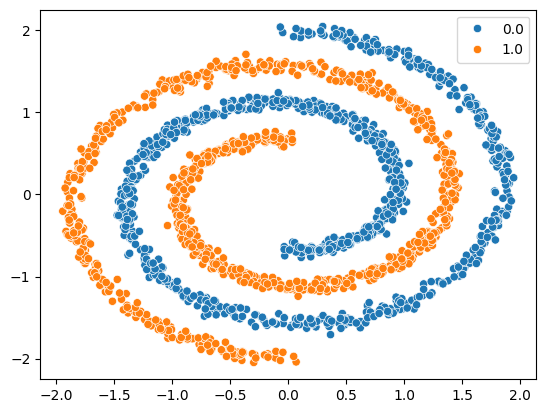

In [6]:
from sklearn.datasets import make_circles, make_swiss_roll
from sklearn.utils import shuffle
import seaborn as sns

def make_swiss_dataset(num_samples):
    X0, _ = make_swiss_roll(num_samples // 2, noise=0.3, random_state=0)
    X1, _ = make_swiss_roll(num_samples // 2, noise=0.3, random_state=0)
    X0 = X0[:, [0, 2]]
    X1 = X1[:, [0, 2]]
    X1 = -X1
    X, y = shuffle(
        np.concatenate([X0, X1], axis=0),
        np.concatenate([np.zeros(len(X0)), np.ones(len(X1))], axis=0),
        random_state=0)
    X = (X - X.mean(axis=0)) / X.std(axis=0)

    return X, y

X, y = make_swiss_dataset(2000)

sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y);

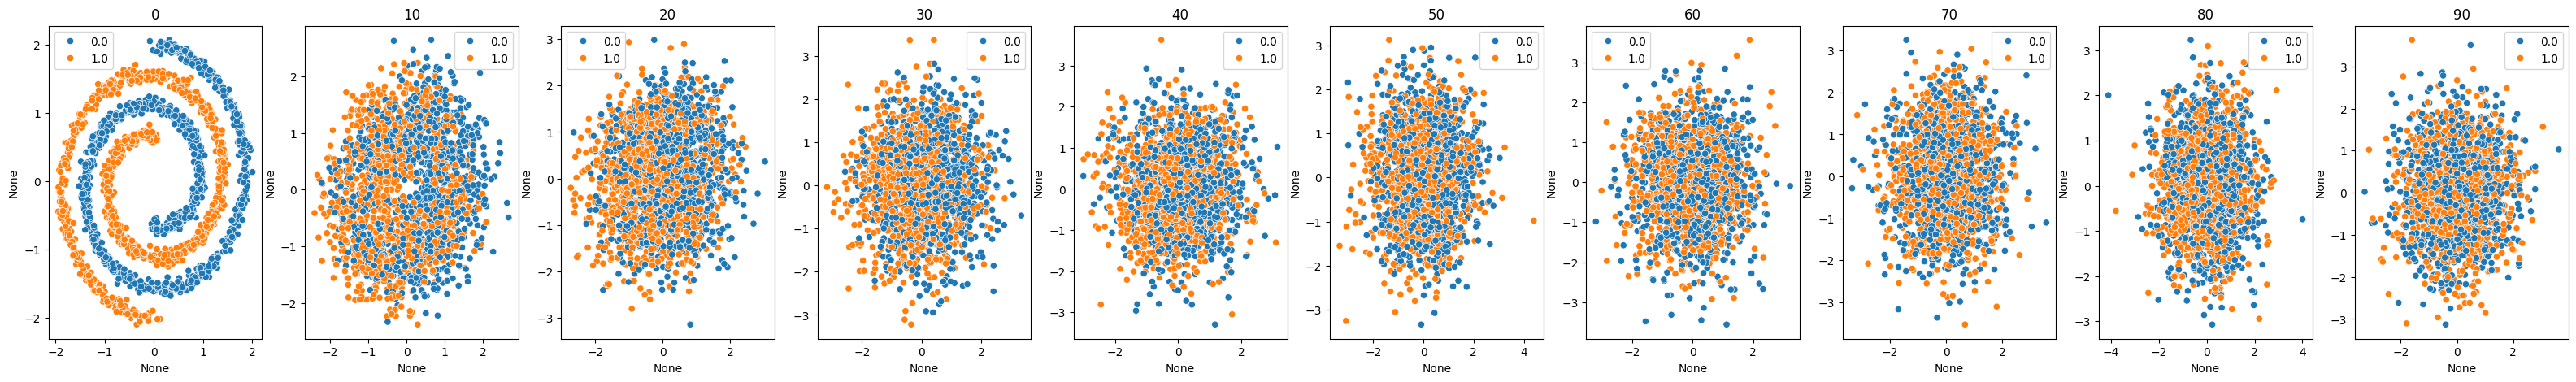

In [7]:
import matplotlib.pyplot as plt

def show_noising(diffusion, X, y):
    fig, axs = plt.subplots(1, 10, figsize=(40, 5))
    for i,t in enumerate(range(0, diffusion.num_timesteps, 10)):
        x = diffusion.q_sample(
           x_start=torch.from_numpy(X),
            t=torch.ones_like(torch.from_numpy(y)).long() * t,
        )

        sns.scatterplot(x=x[:,0], y=x[:,1], hue=y, ax=axs[i])
        axs[i].set(title=t)

show_noising(diffusion, X, y)

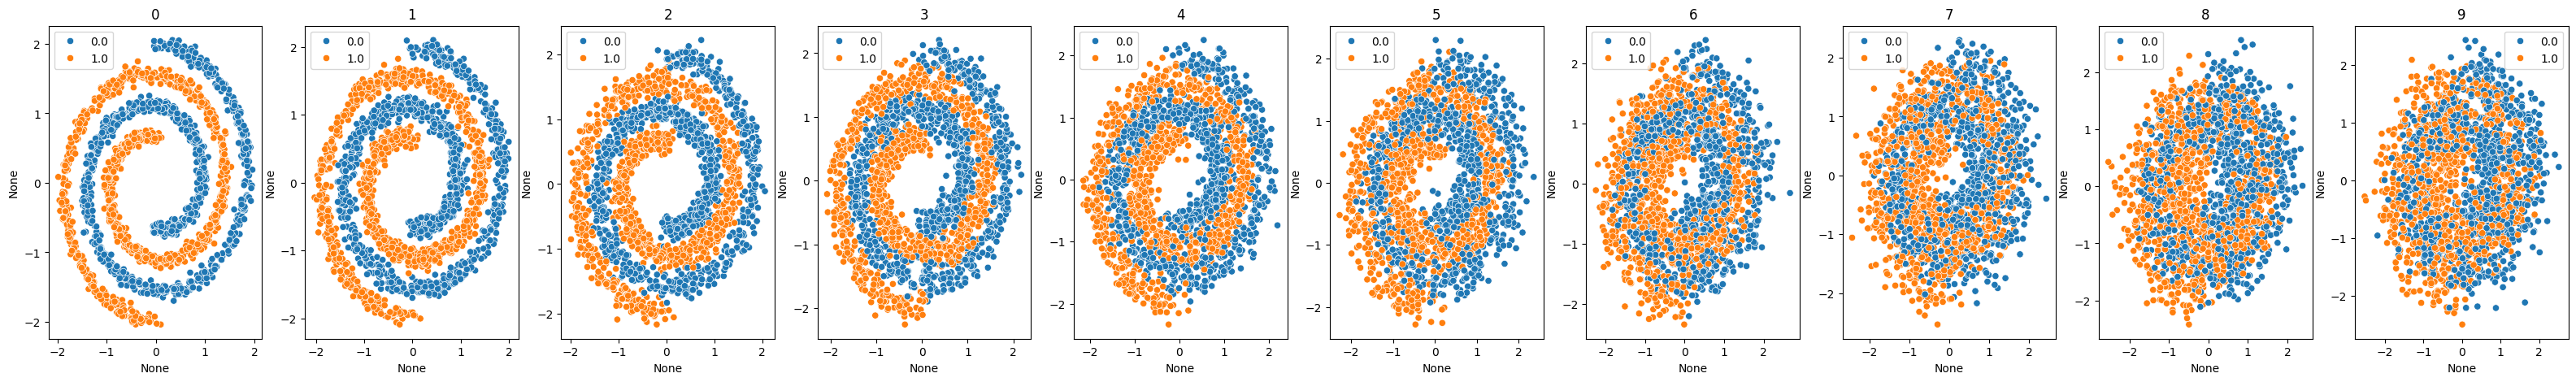

In [8]:
fig, axs = plt.subplots(1, 10, figsize=(40, 5))
for i,t in enumerate(range(0, 10, 1)):
        x = diffusion.q_sample(
           x_start=torch.from_numpy(X),
            t=torch.ones_like(torch.from_numpy(y)).long() * t,
        )

        sns.scatterplot(x=x[:,0], y=x[:,1], hue=y, ax=axs[i])
        axs[i].set(title=t)

One-dimensional conditional UNET

Если хотим в fp16 обучать, как в статье

In [6]:
def convert_module_to_f16(l):
    """
    Convert primitive modules to float16.
    """
    if isinstance(l, (nn.Conv1d, nn.Conv2d, nn.Conv3d)):
        l.weight.data = l.weight.data.half()
        l.bias.data = l.bias.data.half()


def convert_module_to_f32(l):
    """
    Convert primitive modules to float32, undoing convert_module_to_f16().
    """
    if isinstance(l, (nn.Conv1d, nn.Conv2d, nn.Conv3d)):
        l.weight.data = l.weight.data.float()
        l.bias.data = l.bias.data.float()

Utils

In [7]:
class GroupNorm32(nn.GroupNorm):
    def forward(self, x):
        return super().forward(x.float()).type(x.dtype)


def zero_module(module):
    """
    Zero out the parameters of a module and return it.
    """
    for p in module.parameters():
        p.detach().zero_()
    return module


def normalization(channels):
    """
    Make a standard normalization layer.

    :param channels: number of input channels.
    :return: an nn.Module for normalization.
    """
    return GroupNorm32(32, channels)


def timestep_embedding(timesteps, dim, max_period=10000):
    """
    Create sinusoidal timestep embeddings.

    :param timesteps: a 1-D Tensor of N indices, one per batch element.
                      These may be fractional.
    :param dim: the dimension of the output.
    :param max_period: controls the minimum frequency of the embeddings.
    :return: an [N x dim] Tensor of positional embeddings.
    """
    half = dim // 2
    freqs = torch.exp(
        -math.log(max_period) * torch.arange(start=0, end=half, dtype=torch.float32) / half
    ).to(device=timesteps.device)
    args = timesteps[:, None].float() * freqs[None]
    embedding = torch.cat([torch.cos(args), torch.sin(args)], dim=-1)
    if dim % 2:
        embedding = torch.cat([embedding, torch.zeros_like(embedding[:, :1])], dim=-1)
    return embedding

Основные классы

In [8]:
from abc import abstractmethod
import math
import numpy as np
import torch.nn as nn
import torch.nn.functional as F


class TimestepBlock(nn.Module):
    """
    Any module where forward() takes timestep embeddings as a second argument.
    """

    @abstractmethod
    def forward(self, x, emb):
        """
        Apply the module to `x` given `emb` timestep embeddings.
        """


class TimestepEmbedSequential(nn.Sequential, TimestepBlock):
    """
    A sequential module that passes timestep embeddings to the children that
    support it as an extra input.
    """

    def forward(self, x, emb):
        for layer in self:
            if isinstance(layer, TimestepBlock):
                x = layer(x, emb)
            else:
                x = layer(x)
        return x


class Upsample(nn.Module):
    """
    An upsampling layer with an optional convolution.

    :param channels: channels in the inputs and outputs.
    :param use_conv: a bool determining if a convolution is applied.
    """

    def __init__(self, channels, use_conv):
        super().__init__()
        self.channels = channels
        self.use_conv = use_conv
        if use_conv:
            self.conv = nn.Conv1d(channels, channels, 3, padding=1)

    def forward(self, x):
        assert x.shape[1] == self.channels
        x = F.interpolate(x, scale_factor=2, mode="nearest")
        if self.use_conv:
            x = self.conv(x)
        return x


class Downsample(nn.Module):
    """
    A downsampling layer with an optional convolution.

    :param channels: channels in the inputs and outputs.
    :param use_conv: a bool determining if a convolution is applied.
    """

    def __init__(self, channels, use_conv):
        super().__init__()
        self.channels = channels
        self.use_conv = use_conv
        stride = 2
        if use_conv:
            self.op = nn.Conv1d(channels, channels, 3, stride=stride, padding=1)
        else:
            self.op = nn.AvgPool1d(stride)

    def forward(self, x):
        assert x.shape[1] == self.channels
        return self.op(x)


class ResBlock(TimestepBlock):
    """
    A residual block that can optionally change the number of channels.

    :param channels: the number of input channels.
    :param emb_channels: the number of timestep embedding channels.
    :param dropout: the rate of dropout.
    :param out_channels: if specified, the number of out channels.
    :param use_conv: if True and out_channels is specified, use a spatial
        convolution instead of a smaller 1x1 convolution to change the
        channels in the skip connection.
    """

    def __init__(
        self,
        channels,
        emb_channels,
        dropout,
        out_channels=None,
        use_conv=False,
        use_scale_shift_norm=False,
    ):
        super().__init__()
        self.channels = channels
        self.emb_channels = emb_channels
        self.dropout = dropout
        self.out_channels = out_channels or channels
        self.use_conv = use_conv
        self.use_scale_shift_norm = use_scale_shift_norm

        self.in_layers = nn.Sequential(
            normalization(channels),
            nn.SiLU(),
            nn.Conv1d(channels, self.out_channels, 3, padding=1),
        )
        self.emb_layers = nn.Sequential(
            nn.SiLU(),
            nn.Linear(
                emb_channels,
                2 * self.out_channels if use_scale_shift_norm else self.out_channels,
            ),
        )
        self.out_layers = nn.Sequential(
            normalization(self.out_channels),
            nn.SiLU(),
            nn.Dropout(p=dropout),
            zero_module(
                nn.Conv1d(self.out_channels, self.out_channels, 3, padding=1)
            ),
        )

        if self.out_channels == channels:
            self.skip_connection = nn.Identity()
        elif use_conv:
            self.skip_connection = nn.Conv1d(
                channels, self.out_channels, 3, padding=1
            )
        else:
            self.skip_connection = nn.Conv1d(channels, self.out_channels, 1)

    def forward(self, x, emb):
        h = self.in_layers(x)
        emb_out = self.emb_layers(emb).type(h.dtype)
        while len(emb_out.shape) < len(h.shape):
            emb_out = emb_out[..., None]
        if self.use_scale_shift_norm:
            out_norm, out_rest = self.out_layers[0], self.out_layers[1:]
            scale, shift = torch.chunk(emb_out, 2, dim=1)
            h = out_norm(h) * (1 + scale) + shift
            h = out_rest(h)
        else:
            h = h + emb_out
            h = self.out_layers(h)
        return self.skip_connection(x) + h


class AttentionBlock(nn.Module):
    """
    An attention block that allows spatial positions to attend to each other.
    """

    def __init__(self, channels, num_heads=1):
        super().__init__()
        self.channels = channels
        self.num_heads = num_heads

        self.norm = normalization(channels)
        self.qkv = nn.Conv1d(channels, channels * 3, 1)
        self.attention = QKVAttention()
        self.proj_out = zero_module(nn.Conv1d(channels, channels, 1))

    def forward(self, x):
        b, c, *spatial = x.shape
        x = x.reshape(b, c, -1)
        qkv = self.qkv(self.norm(x))
        qkv = qkv.reshape(b * self.num_heads, -1, qkv.shape[2])
        h = self.attention(qkv)
        h = h.reshape(b, -1, h.shape[-1])
        h = self.proj_out(h)
        return (x + h).reshape(b, c, *spatial)


class QKVAttention(nn.Module):
    """
    A module which performs QKV attention.
    """

    def forward(self, qkv):
        """
        Apply QKV attention.

        :param qkv: an [N x (C * 3) x T] tensor of Qs, Ks, and Vs.
        :return: an [N x C x T] tensor after attention.
        """
        ch = qkv.shape[1] // 3
        q, k, v = torch.split(qkv, ch, dim=1)
        scale = 1 / math.sqrt(math.sqrt(ch))
        weight = torch.einsum(
            "bct,bcs->bts", q * scale, k * scale
        )  # More stable with f16 than dividing afterwards
        weight = torch.softmax(weight.float(), dim=-1).type(weight.dtype)
        return torch.einsum("bts,bcs->bct", weight, v)


class UNetModel(nn.Module):
    """
    The full UNet model with attention and timestep embedding.

    :param in_channels: channels in the input Tensor.
    :param model_channels: base channel count for the model.
    :param out_channels: channels in the output Tensor.
    :param num_res_blocks: number of residual blocks per downsample.
    :param attention_resolutions: a collection of downsample rates at which
        attention will take place. May be a set, list, or tuple.
        For example, if this contains 4, then at 4x downsampling, attention
        will be used.
    :param dropout: the dropout probability.
    :param channel_mult: channel multiplier for each level of the UNet.
    :param conv_resample: if True, use learned convolutions for upsampling and
        downsampling.
    :param num_classes: if specified (as an int), then this model will be
        class-conditional with `num_classes` classes.
    :param num_heads: the number of attention heads in each attention layer.
    """

    def __init__(
        self,
        in_channels,
        model_channels,
        out_channels,
        num_res_blocks,
        attention_resolutions,
        dropout=0,
        channel_mult=(1, 2, 4, 8),
        conv_resample=True,
        num_classes=None,
        num_heads=1,
        num_heads_upsample=-1,
        use_scale_shift_norm=False,
    ):
        super().__init__()

        if num_heads_upsample == -1:
            num_heads_upsample = num_heads

        self.in_channels = in_channels
        self.model_channels = model_channels
        self.out_channels = out_channels
        self.num_res_blocks = num_res_blocks
        self.attention_resolutions = attention_resolutions
        self.dropout = dropout
        self.channel_mult = channel_mult
        self.conv_resample = conv_resample
        self.num_classes = num_classes
        self.num_heads = num_heads
        self.num_heads_upsample = num_heads_upsample

        time_embed_dim = model_channels * 4
        self.time_embed = nn.Sequential(
            nn.Linear(model_channels, time_embed_dim),
            nn.SiLU(),
            nn.Linear(time_embed_dim, time_embed_dim),
        )

        if self.num_classes is not None:
            self.label_emb = nn.Embedding(num_classes, time_embed_dim)

        self.input_blocks = nn.ModuleList(
            [
                TimestepEmbedSequential(
                    nn.Conv1d(in_channels, model_channels, 3, padding=1)
                )
            ]
        )
        input_block_chans = [model_channels]
        ch = model_channels
        ds = 1
        for level, mult in enumerate(channel_mult):
            for _ in range(num_res_blocks):
                layers = [
                    ResBlock(
                        ch,
                        time_embed_dim,
                        dropout,
                        out_channels=mult * model_channels,
                        use_scale_shift_norm=use_scale_shift_norm,
                    )
                ]
                ch = mult * model_channels
                if ds in attention_resolutions:
                    layers.append(
                        AttentionBlock(
                            ch, num_heads=num_heads
                        )
                    )
                self.input_blocks.append(TimestepEmbedSequential(*layers))
                input_block_chans.append(ch)
            if level != len(channel_mult) - 1:
                self.input_blocks.append(
                    TimestepEmbedSequential(Downsample(ch, conv_resample))
                )
                input_block_chans.append(ch)
                ds *= 2

        self.middle_block = TimestepEmbedSequential(
            ResBlock(
                ch,
                time_embed_dim,
                dropout,
                use_scale_shift_norm=use_scale_shift_norm,
            ),
            AttentionBlock(ch, num_heads=num_heads),
            ResBlock(
                ch,
                time_embed_dim,
                dropout,
                use_scale_shift_norm=use_scale_shift_norm,
            ),
        )

        self.output_blocks = nn.ModuleList([])
        for level, mult in list(enumerate(channel_mult))[::-1]:
            for i in range(num_res_blocks + 1):
                layers = [
                    ResBlock(
                        ch + input_block_chans.pop(),
                        time_embed_dim,
                        dropout,
                        out_channels=model_channels * mult,
                        use_scale_shift_norm=use_scale_shift_norm,
                    )
                ]
                ch = model_channels * mult
                if ds in attention_resolutions:
                    layers.append(
                        AttentionBlock(
                            ch,
                            num_heads=num_heads_upsample,
                        )
                    )
                if level and i == num_res_blocks:
                    layers.append(Upsample(ch, conv_resample))
                    ds //= 2
                self.output_blocks.append(TimestepEmbedSequential(*layers))

        self.out = nn.Sequential(
            normalization(ch),
            nn.SiLU(),
            zero_module(nn.Conv1d(model_channels, out_channels, 3, padding=1)),
        )

    def convert_to_fp16(self):
        """
        Convert the torso of the model to float16.
        """
        self.input_blocks.apply(convert_module_to_f16)
        self.middle_block.apply(convert_module_to_f16)
        self.output_blocks.apply(convert_module_to_f16)

    def convert_to_fp32(self):
        """
        Convert the torso of the model to float32.
        """
        self.input_blocks.apply(convert_module_to_f32)
        self.middle_block.apply(convert_module_to_f32)
        self.output_blocks.apply(convert_module_to_f32)

    @property
    def inner_dtype(self):
        """
        Get the dtype used by the torso of the model.
        """
        return next(self.input_blocks.parameters()).dtype

    def forward(self, x, timesteps, y=None):
        """
        Apply the model to an input batch.

        :param x: an [N x C x ...] Tensor of inputs.
        :param timesteps: a 1-D batch of timesteps.
        :param y: an [N] Tensor of labels, if class-conditional.
        :return: an [N x C x ...] Tensor of outputs.
        """
        assert (y is not None) == (
            self.num_classes is not None
        ), "must specify y if and only if the model is class-conditional"

        hs = []
        emb = self.time_embed(timestep_embedding(timesteps, self.model_channels))

        if self.num_classes is not None:
            assert y.shape == (x.shape[0],)
            emb = emb + self.label_emb(y)

        h = x.type(self.inner_dtype)
        for module in self.input_blocks:
            h = module(h, emb)
            hs.append(h)
        h = self.middle_block(h, emb)
        for module in self.output_blocks:
            cat_in = torch.cat([h, hs.pop()], dim=1)
            h = module(cat_in, emb)
        h = h.type(x.dtype)
        return self.out(h)

    def get_feature_vectors(self, x, timesteps, y=None):                        # из middle, например, можно выудить латентное представление
        """
        Apply the model and return all of the intermediate tensors.

        :param x: an [N x C x ...] Tensor of inputs.
        :param timesteps: a 1-D batch of timesteps.
        :param y: an [N] Tensor of labels, if class-conditional.
        :return: a dict with the following keys:
                 - 'down': a list of hidden state tensors from downsampling.
                 - 'middle': the tensor of the output of the lowest-resolution
                             block in the model.
                 - 'up': a list of hidden state tensors from upsampling.
        """
        hs = []
        emb = self.time_embed(timestep_embedding(timesteps, self.model_channels))
        if self.num_classes is not None:
            assert y.shape == (x.shape[0],)
            emb = emb + self.label_emb(y)
        result = dict(down=[], up=[])
        h = x.type(self.inner_dtype)
        for module in self.input_blocks:
            h = module(h, emb)
            hs.append(h)
            result["down"].append(h.type(x.dtype))
        h = self.middle_block(h, emb)
        result["middle"] = h.type(x.dtype)
        for module in self.output_blocks:
            cat_in = torch.cat([h, hs.pop()], dim=1)
            h = module(cat_in, emb)
            result["up"].append(h.type(x.dtype))
        return result

    def sample(self, batch_size, genres=None, length=2**8 * 3):
        if not genres:
            genres = torch.randint(low=0, high=8, size=[batch_size], dtype=torch.long, device=device)
        genre_embed = self.genre_embed(genres)
        sample = torch.randn(size=[batch_size, self.final_size, length]).to(device) + genre_embed.unsqueeze(dim=-1)
        return self.decoder(sample)

In [16]:
model = UNetModel(in_channels=32, model_channels=32, out_channels=32, num_res_blocks=2, attention_resolutions=[1,2,4])

dummy_tensor = torch.rand(64, 32, 16) # batch_size x n_channels x n_frames (степень двойки лучше n_frames, иначе падает из-за несостыковок)
time = torch.randint(0, 1000, (64,)).float()
model(dummy_tensor, time).size(), model.get_feature_vectors(dummy_tensor, time)['middle'].size()

(torch.Size([64, 32, 16]), torch.Size([64, 512, 1]))

Обучение

In [26]:
from tqdm import trange
from IPython.display import clear_output
import matplotlib.pyplot as plt

In [28]:
from typing import List, Tuple

def sample_synthetic(
    diffusion: Diffusion,
    model: nn.Module,
    num_samples: int,
    batch: int = 8,
    shape: Tuple = (1, 2**15 * 6),
    y_dist: List[int] = [1/8] * 8,
    ddim: bool = False,
):
    sample_func = diffusion.p_sample_loop
    if ddim:
        sample_func = diffusion.ddim_sample
    res_x = []
    res_y = []
    num_sampled = 0
    while num_sampled < num_samples:
        x, y = sample_func(
            model,
            shape=(batch, *shape),
            y_dist=torch.tensor(y_dist)
        )
        res_x.append(x.cpu())
        res_y.append(y.cpu())
        num_sampled += batch

    res_x = torch.cat(res_x, dim=0)
    res_y = torch.cat(res_y, dim=0)
    return res_x[:num_samples], res_y[:num_samples]

In [29]:
from copy import deepcopy
import pandas as pd


class Trainer:
    def __init__(
        self,
        diffusion: Diffusion,
        model: nn.Module,
        dataloader,
        lr: float,
        weight_decay: float,
        epochs: int,
        device: torch.device = torch.device('cuda')
    ):
        self.diffusion = diffusion
        self.dataloader = dataloader
        self.init_lr = lr
        self.model = model
        self.optimizer = torch.optim.AdamW(self.model.parameters(), lr=lr, weight_decay=weight_decay)
        self.device = device
        self.log_every = 100
        self.print_every = 500
        self.save_every = 2000           # можно поменять, если сохраняет слишком часто

    def _anneal_lr(self, step: int):
        """
        Performs annealing of lr.
        """

        frac_done = step / self.epochs * len(self.dataloader)
        lr = self.init_lr * (1 - frac_done)
        for param_group in self.optimizer.param_groups:
            param_group["lr"] = lr

    def _run_step(self, x: torch.FloatTensor, y: torch.LongTensor):
        """
        A single training step.
        Calculates loss for a single batch.
        Then performs a single optimizer step and returns loss.
        """
        loss = self.diffusion.train_loss(model, x, y)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        return loss

    def run_loop(self):
        """
        Training loop.
        """
        step = 0
        curr_loss_gauss = 0.0
        epoch = 0
        curr_count = 0
        steps = []
        losses = []

        while epoch < self.epochs:
            epoch += 1
            for batch_idx, (data, genre) in enumerate(dataloader):
                data = data.to(device).unsqueeze(dim=1)
                genre = genre.to(device)
                batch_loss = self._run_step(data, genre)

                self._anneal_lr(step)

                curr_count += len(x)
                curr_loss_gauss += batch_loss.item() * len(x)

                if (step + 1) % self.log_every == 0:
                    gloss = np.around(curr_loss_gauss / curr_count, 4)
                    steps.append(step)
                    losses.append(gloss)
                    if (step + 1) % self.print_every == 0:
                        clear_output(True)
                        print(f'Step {(step + 1)}/{self.epochs} Loss: {gloss}')

                        plt.title("Loss")
                        plt.plot(steps, losses)
                        plt.grid()
                        plt.show()

                    curr_count = 0
                    curr_loss_gauss = 0.0

                if (step + 1) % self.save_every == 0:
                  Xs, ys = sample_synthetic(
                                              diffusion,
                                              model,
                                              num_samples=1,
                                              batch = 8,
                                              shape=(1, 2**15 * 6),
                                              y_dist = [1/8 for _ in range(10)]
                                            )
                  sample = Xs[0].numpy(force=True)
                  ipd.Audio(data=sample, rate=44100)
                  np.save('generated_step'+str(step), sample)
                  torch.save(model, "model#"+str(step))

                step += 1

In [20]:
model = UNetModel(in_channels=1, model_channels=32, out_channels=1, num_res_blocks=2,
                  attention_resolutions=[1,2,3,4], num_classes=8,
                  channel_mult=(1, 2, 4, 8)) # можно тут сделать channel_mult=(1, 2, 4, 8, 16), тогда будет 20М параметров
dummy_tensor = torch.rand(64, 1, 2**8 * 6)
time = torch.randint(0, 1000, (64,)).float()
dummy_y = torch.randint(0, 7, (64,))
print(model(dummy_tensor, time, dummy_y).size())
print(f"Model has {sum([p.numel() for p in model.parameters()])} parameters")

torch.Size([64, 1, 1536])
Model has 5974401 parameters


In [22]:
T = 1000

diffusion = Diffusion(
    betas=get_named_beta_schedule('linear', T),
    loss_type="mse"
)

In [27]:
trainer = Trainer(
    diffusion,
    model,
    dataloader=dataloader,
    lr=3e-4,
    weight_decay=0.0,
    epochs=10,
    device=device
)

In [ ]:
trainer.run_loop()

DDIM (пока без Sampling with guidance gradients)

Статья: [Denoising Diffusion Implicit Models, Song et al., 2020](https://arxiv.org/abs/2010.02502).

Идея следущая: давайте изменим прямой диффузионный процесс так, чтобы используя предобученную DDPM, приближать новый обратный процесс за меньшее число шагов.

Чтобы не обучать новую модель, нам нужен прямой диффузионный процесс, у которого будет такая же функция потерь (MSE на шум), а обратный процесс все еще останется марковским. Оказалось, что существует целое семейство немарковских прямых процессов, удовлетворяющих этим требования. Это семейство имеет следующий вид (индуцируемое $\sigma \in \mathbb{R}^T$):

![ddim](https://i.imgur.com/lB2KaOR.png)

Распределения выше были выбраны так, чтобы $q(x_t | x_0)$ оставалось таким же, как раньше. Это можно проверить, используя формулу Байеса и свойства нормальных распределений.

Тогда обратный пройесс можно переписать как $q_{\sigma}(x_{t-1}|x_t, \hat{x}_{0}(x_t))$ или же:

\begin{equation*}
    x_{t-1} = \sqrt{\alpha_{t-1}} \underbrace{\left(\frac{x_t - \sqrt{1 - \alpha_t} \epsilon_\theta^{(t)}(x_t)}{\sqrt{\alpha_t}}\right)}_{\text{`` predicted } x_0 \text{''}} + \underbrace{\sqrt{1 - \alpha_{t-1} - \sigma_t^2} \cdot \epsilon_\theta^{(t)}(x_t)}_{\text{``direction pointing to } x_t \text{''}} + \underbrace{\sigma_t \epsilon_t}_{\text{random noise}}  \quad \quad \quad \quad \quad \quad (8)
\end{equation*}

Теперь давайте скажем, что $\sigma_t(\eta) = \eta\sqrt{(1 - \alpha_{t - 1})(1 - \alpha_t)}\sqrt{1 - \alpha_t / \alpha_{t - 1}}$, тогда при $\eta = 1$ равенство (8) превращается в DDPM сэмплирование. При $\eta = 0$ у нас $\sigma_t = 0$ и пропадает третья компонента стохастичности, что и называется DDIM сэмплирование. Таким образом, у нас есть детерминистичный процесс сэмплирования: при заданном начальном латенте мы всегда насэмлируем один и тот же $x_0$. Также можно достичь ускорения сэмплирования, выбирая лишь подмножество шагов $0 \leq \tau_1 \leq ... \leq \tau_S \leq T, \ \ \ S < T$ и сэмплируя с помощью DDIM по ним.

Поскольку процесс детерминистичный, то мы можем инвертировать равенство (8) и получить $x_t(x_{t - 1})$, то есть процесс зашумления (reversed DDIM).

Все вышеописанное может быть полезно для осмысленных интерполяций в латентом пространстве (взяли две картинки, сделали обратный DDIM, получили два шума, как-то их проинтерполировали, расшумили DDIM, получили что-то среднее).

Важно отметить, что нам не нужно переучивать модель, чтобы пользоваться DDIM.

In [15]:
class DiffusionWithDDIM(Diffusion):
    def __init__(self, *args, **kwargs):
        super(DiffusionWithDDIM, self).__init__(*args, **kwargs)

    @torch.no_grad()
    def ddim_step(
        self,
        model_out: torch.FloatTensor,
        x: torch.FloatTensor,
        t: torch.LongTensor,
        eta: float = 0.0
    ):
        """
        Performs ddim step. Use equation (8).
        """

        eps = model_out

        alpha_bar = _extract_into_tensor(self.alphas_cumprod, t, x.shape)
        alpha_bar_prev = _extract_into_tensor(self.alphas_cumprod_prev, t, x.shape)
        sigma = (
            eta
            * torch.sqrt((1 - alpha_bar_prev) / (1 - alpha_bar))
            * torch.sqrt(1 - alpha_bar / alpha_bar_prev)
        )

        noise = torch.randn_like(x)
        mean_pred = (
            self._predict_xstart_from_eps(x, t, model_out) * torch.sqrt(alpha_bar_prev)
            + torch.sqrt(1 - alpha_bar_prev - sigma ** 2) * eps
        )
        nonzero_mask = nonzero_mask = (
            (t != 0).float().view(-1, *([1] * (len(x.shape) - 1)))
        )  # no noise when t == 0
        sample = mean_pred + nonzero_mask * sigma * noise

        return sample

# Тут надо насчет y-ков посмотреть (зависит от данных)

    @torch.no_grad()
    def ddim_sample(
        self,
        model: nn.Module,
        shape: Tuple,
        y_dist: torch.FloatTensor,
        y: torch.LongTensor = None,
        noise: torch.FloatTensor = None,
    ):
        """
        Performs ddim sampling.
        """
        if noise is None:
            x = torch.randn(shape)
        else:
            x = noise

        b = x.shape[0]
        if y is None:
            y = torch.multinomial(
                y_dist,
                num_samples=shape[0],
                replacement=True
            )

        device = x.device
        for t in reversed(range(self.num_timesteps)):
            print(f'Sample timestep {t:4d}', end='\r')
            t_array = (torch.ones(b, device=device) * t).long()
            model_out = model(x, t_array, y)
            x = self.ddim_step(
                model_out,
                x,
                t_array
            )
        print()
        return x

    @torch.no_grad()
    def ddim_reverse_step(
        self,
        model_out,
        x,
        t,
        eta=0.0 # dummy
    ):
        """
        Performs DDIM reverse step, i.e. xt from x_{t-1}. Use equation (8) to derive.
        """
        assert eta == 0.0, "Eta must be zero."

        eps = model_out

        alpha_bar_next = _extract_into_tensor(self.alphas_cumprod_next, t, x.shape)
        mean_pred = (
            self._predict_xstart_from_eps(x, t, model_out) * torch.sqrt(alpha_bar_next)
            + torch.sqrt(1 - alpha_bar_next) * eps
        )

        return mean_pred


    @torch.no_grad()
    def ddim_reverse_sample(
        self,
        model: nn.Module,
        x: torch.FloatTensor,
        y: torch.LongTensor,
    ):
        device = x.device
        b = x.shape[0]
        for t in range(self.num_timesteps):
            t_array = (torch.ones(b, device=device) * t).long()
            model_out = model(x, t_array, y)
            x = self.ddim_reverse_step(
                model_out,
                x,
                t_array,
                eta=0.0
            )
        return x

In [17]:
diffusion_ddim = DiffusionWithDDIM(
    betas=get_named_beta_schedule('linear', 1000),
    loss_type="mse"
)